In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%%time
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")
aexp = data.properties['a']
data.physical_units()
r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir
sph_5 = pynbody.filt.Sphere(radius = '5.0 kpc') # %(r_e*1.4))
region = data[sph_5]
rho = region.gas["rho"].in_units("m_p cm**-3")
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()
for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])


('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))
omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18
CPU times: user 23.8 s, sys: 19.3 s, total: 43.1 s
Wall time: 55.1 s


In [4]:
%%time
m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
turb = np.sqrt( region.g["turb"] * 2./3. ) * unit_l / unit_t / 1e5
turb = pynbody.array.SimArray(turb*1e5, units = "cm s**-1")
T = region.g["temp"]
c_s = np.sqrt(K_b * T / m_p)
mach_no_sim = turb / c_s
region.g["mach"] = mach_no_sim.in_units("1")
m_p_1 = pynbody.array.SimArray(1.0, pynbody.units.m_p)
n_H_mean_sim = rho / m_p_1
G_o = 1

CPU times: user 91.1 ms, sys: 83.6 ms, total: 175 ms
Wall time: 173 ms


In [6]:
%%time
#multiplied X_H2_bar with 2 during the 1.1 iteration
X_H2_bar = np.load('outputs/2.1/X_H2_bar_2.1.npy')
min_X = np.min(X_H2_bar)
max_X = np.max(X_H2_bar)

CPU times: user 1.65 ms, sys: 5.7 ms, total: 7.35 ms
Wall time: 5.92 ms


In [7]:
n_H_mean_arr = np.load('outputs/2.1/n_H_mean_arr_2.1.npy')
mach_no_arr = np.load('outputs/2.1/mach_no_arr_2.1.npy')
Z_arr = np.load('outputs/2.1/Z_arr_2.1.npy')
min_n_H = np.log10(np.min(n_H_mean_sim))
max_n_H = np.log10(np.max(n_H_mean_sim))
min_M = np.min(mach_no_sim)
max_M = np.max(mach_no_sim)
min_Z = np.min(Z_arr)
max_Z = np.max(Z_arr)

In [8]:
%%time
#multiplied X_CO_bar with 2 during the 1.1 iteration
X_CO_bar = np.load('outputs/2.1/X_CO_bar_2.1.npy')
min_C = np.min(X_CO_bar)
max_C = np.max(X_CO_bar)

CPU times: user 594 µs, sys: 4.62 ms, total: 5.21 ms
Wall time: 4.35 ms


In [9]:
region.gas["X_H2_bar"] = X_H2_bar
region.gas["n_H_mean_arr"] = n_H_mean_arr
region.gas["X_CO_bar"] = X_CO_bar
region.gas["Z_arr"] = Z_arr
region.gas["mach_no_arr"] = mach_no_arr

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


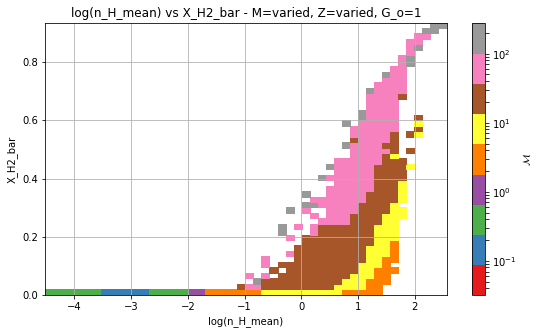

CPU times: user 1.09 s, sys: 20.4 ms, total: 1.11 s
Wall time: 1.13 s


In [16]:
%%time
plt.figure(figsize=(9,5))
histX_H2_M_mass, yedges, xedges = np.histogram2d(X_H2_bar, np.log10(n_H_mean_arr),
                               weights=mach_no_arr * region.gas["mass"], bins=50 , range=[[min_X,max_X],[min_n_H,max_n_H]])
histX_H2_mass, yedges, xedges = np.histogram2d(X_H2_bar, np.log10(n_H_mean_arr),
                               weights=region.gas["mass"], bins=50 , range=[[min_X,max_X],[min_n_H,max_n_H]])

yX_H2_M, xX_H2_M = yedges, xedges
plt.pcolormesh(xedges, yedges, histX_H2_M_mass/histX_H2_mass, norm=LogNorm(), vmin=min_M, vmax=max_M, cmap="Set1")
plt.colorbar(label=r"$\mathcal{M}$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_H2_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_H2_bar - M=varied, Z=varied, G_o=1')
plt.savefig('outputs/2.1/Hist-X_H2_bar-n_H_mean-2.1.png', dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


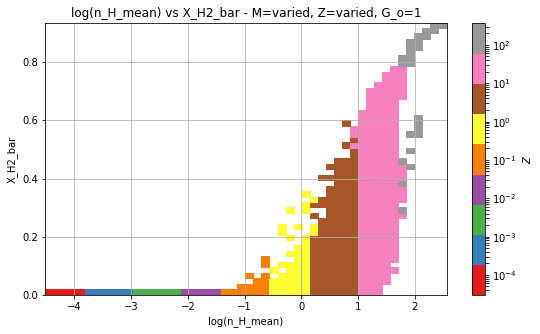

CPU times: user 1.38 s, sys: 41.3 ms, total: 1.42 s
Wall time: 1.46 s


In [17]:
%%time
plt.figure(figsize=(9,5))
histX_H2_M_mass, yedges, xedges = np.histogram2d(X_H2_bar, np.log10(n_H_mean_arr),
                               weights=Z_arr * region.gas["mass"], bins=50 , range=[[min_X,max_X],[min_n_H,max_n_H]])
histX_H2_mass, yedges, xedges = np.histogram2d(X_H2_bar, np.log10(n_H_mean_arr),
                               weights=region.gas["mass"], bins=50 , range=[[min_X,max_X],[min_n_H,max_n_H]])

yX_H2_M, xX_H2_M = yedges, xedges
plt.pcolormesh(xedges, yedges, histX_H2_M_mass/histX_H2_mass, norm=LogNorm(), vmin=min_Z, vmax=max_Z, cmap="Set1")
plt.colorbar(label="$Z$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_H2_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_H2_bar - M=varied, Z=varied, G_o=1')
plt.savefig('outputs/2.1/Hist-X_H2_bar-n_H_mean_Z-2.1.png', dpi=300, bbox_inches='tight')
plt.show()

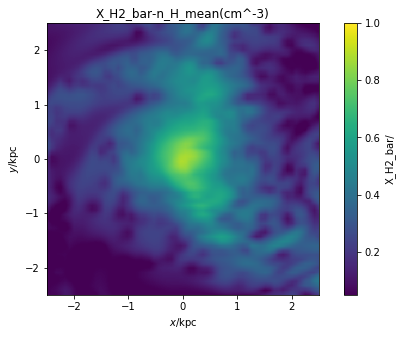

In [26]:
plt.figure(figsize=(9,5))
pynbody.plot.image(region.g, qty="X_H2_bar", width='5.0 kpc',
                   log=False, resolution=500, cmap="viridis", av_z="n_H_mean_arr",
                   vmin=5e-2, vmax=1)
plt.title("X_H2_bar-n_H_mean(cm^-3)")
plt.savefig('outputs/2.1/X_H2_bar-n_H_mean-2.1.png', dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


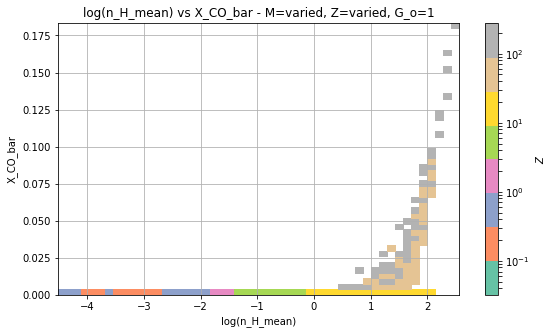

CPU times: user 1.12 s, sys: 4.35 ms, total: 1.12 s
Wall time: 1.13 s


In [19]:
%%time
plt.figure(figsize=(9,5))
histX_CO_M_mass, y1edges, x1edges = np.histogram2d(X_CO_bar, np.log10(n_H_mean_arr),
                               weights=mach_no_arr * region.gas["mass"], bins=50 , range=[[min_C,max_C],[min_n_H,max_n_H]])
histX_CO_mass, y1edges, x1edges = np.histogram2d(X_CO_bar, np.log10(n_H_mean_arr),
                               weights=region.gas["mass"], bins=50 , range=[[min_C,max_C],[min_n_H,max_n_H]])

yX_CO_M, xX_CO_M = y1edges, x1edges
plt.pcolormesh(x1edges, y1edges, histX_CO_M_mass/histX_CO_mass, norm=LogNorm(), vmin=min_M, vmax=max_M, cmap="Set2")
plt.colorbar(label="$Z$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_CO_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_CO_bar - M=varied, Z=varied, G_o=1')
plt.savefig('outputs/2.1/Hist-X_CO_bar-n_H_mean-2.1.png', dpi=300, bbox_inches='tight')
plt.show()


/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


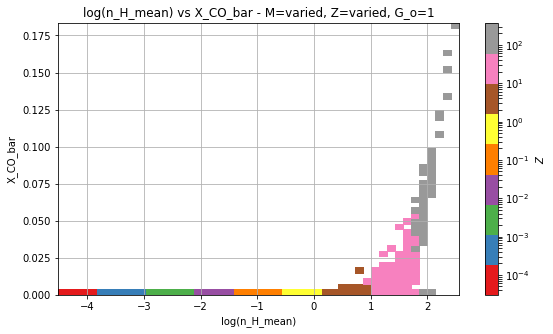

CPU times: user 1.46 s, sys: 33.6 ms, total: 1.5 s
Wall time: 1.5 s


In [20]:
%%time
plt.figure(figsize=(9,5))
histX_CO_M_mass, y1edges, x1edges = np.histogram2d(X_CO_bar, np.log10(n_H_mean_arr),
                               weights=Z_arr * region.gas["mass"], bins=50 , range=[[min_C,max_C],[min_n_H,max_n_H]])
histX_CO_mass, y1edges, x1edges = np.histogram2d(X_CO_bar, np.log10(n_H_mean_arr),
                               weights=region.gas["mass"], bins=50 , range=[[min_C,max_C],[min_n_H,max_n_H]])

yX_CO_M, xX_CO_M = y1edges, x1edges
plt.pcolormesh(x1edges, y1edges, histX_CO_M_mass/histX_CO_mass, norm=LogNorm(), vmin=min_Z, vmax=max_Z, cmap="Set1")
plt.colorbar(label="$Z$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_CO_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_CO_bar - M=varied, Z=varied, G_o=1')
plt.savefig('outputs/2.1/Hist-X_CO_bar-n_H_mean_Z-2.1.png', dpi=300, bbox_inches='tight')
plt.show()



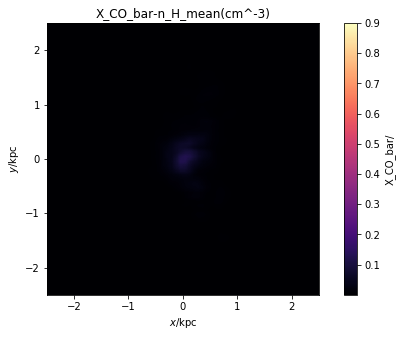

In [28]:
plt.figure(figsize=(9,5))
pynbody.plot.image(region.g, qty="X_CO_bar", width='5.0 kpc',
                   log=False, resolution=500, cmap="magma", av_z="n_H_mean_arr",
                   vmin=5e-10, vmax=9e-1)
plt.title("X_CO_bar-n_H_mean(cm^-3)")
plt.savefig('outputs/2.1/X_CO_bar-n_H_mean-2.1.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
#insert 3D plot

In [16]:
# %%time
# fig = plt.figure(figsize=(9,5))
# ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax.plot_trisurf(X_H2_bar, np.log10(n_H_mean_sim), np.log(mach_no_sim), 
#                    norm=np.log(Z_arr), vmin=np.log(min_Z), vmax=np.log(max_Z), cmap='viridis')
# plt.colorbar(label="$Z$")
# plt.xlabel('log(n_H_mean)')
# plt.ylabel('X_H2_bar')
# plt.zlabel('Mach no.')
# plt.grid(b=True, which='both', axis='both')
# plt.title('log(n_H_mean) vs X_H2_bar - M=varied, Z=varied, G_o=1')

In [27]:
np.max(n_H_mean_sim)

SimArray(369.0627848, 'cm**-3')

In [19]:
np.mean(Z_arr)

1.117304706579003

In [20]:
np.max(Z_arr)

369.06278480473287

In [21]:
np.min(Z_arr)

3.0204050922364867e-05

In [ ]:
plt.hist(np.log10(Z_arr))